**Working on gesture expressivity**

goal : learning the associations between expressive movement qualities and sound qualities.

to mimic a specific behavior of the chosen character using arms’ gestures.

In [1]:
from tkinter import *
import PIL
from PIL import Image, ImageDraw
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import linear_model
from sklearn.metrics import r2_score
from collections import deque
from playsound import playsound
from os import path

# CONSTANTS

In [2]:
# data capture framework
sampling_frequency = 1.0    # sampling frequency of the mouse
canvas_size = (640, 480)    # size in pixels of the canvas for collecting mouse data

# analysis framework
weights = np.array([
    [0.5, 0.5],            # weights for the Space features
    [0.1, 0.9]             # weights for the Time features
])
enable_continuous_analysis = 1    # set it to 1 to enable analysis on a fixed time window, to 0 otherwise
buffer_size = 10                  # size of the fixed time window used for the continuous analysis only

# GLOBAL VARIABLES and DATA STRUCTURES

In [3]:
gesture = list()
lastx, lasty = None, None

def initialize():
    global gesture
    gesture = []
    return

def append(point):
    global gesture
    gesture.append(point)     
    return

# LABAN ANALYSIS functions

## Laban's Space
Space refers to the direction of a motion stroke and to the path followed by a sequence of strokes. If the movement follows these directions smoothly, space is flexible , whereas if it follows them along a straight trajectory, space is direct . Opposite ends: Flexible/Direct

In [4]:
def get_distance(point1, point2):
    distance = np.linalg.norm(point1 - point2)
    return distance

def path_length(points):
    length = 0
    for k in np.arange(len(points)-1):
        length += get_distance(points[k],points[k+1])
    return length

def directness_index(points):
    N = len(points)-1
    dir_index = get_distance(points[0],points[N])/path_length(points)
    return dir_index

def goodness_of_linear_fit(points):
    X = points[:,0].reshape(-1, 1)
    y = points[:,1].reshape(-1, 1)
    regression = linear_model.LinearRegression().fit(X, y)
    r2 = regression.score(X,y)
    return r2

def laban_space(points, weights, canvas_size=(640, 480), display=0):
    s1     = directness_index(points)
    s2     = goodness_of_linear_fit(points)
    score  = weights[0] * s1 + weights[1] * s2
    if (display == 1):
        print("\n--- Laban's Space features ---")
        print("Directness index = {:.2f}".format(s1))
        print("Goodness of fit = {:.2f}".format(s2))
        print("Total Space score = {:.2f}".format(score))
    return score

## Laban's Time
Time is related to “urgency”, to impulsiveness of a movement. Opposite ends: Quick/Sustained

In [5]:
def speed(points, fs=1.0):
    sp = []
    for k in np.arange(len(points)-1):
        sp.append(get_distance(points[k],points[k+1]) * fs)
    return np.array(sp)

def average_normalized_kinetic_energy(points, fs=1.0):
    n   = len(points)
    s2  = speed(points, fs)**2
    kin = sum(s2) / (n*max(s2))
    return kin 
         
def impulsiveness(points, fs=1.0):
    n   = len(points)
    s   = speed(points, fs)
    imp = max(s) / n
    imp = np.arctan(imp)/(np.pi/2) # normalize from [0,+∞[ to [0,1[
    return imp

def laban_time(points, weights, fs=1.0, display=0):
    t1    = average_normalized_kinetic_energy(points)
    t2    = impulsiveness(points)
    score = weights[0] * t1 + weights[1] * t2
    if (display == 1):
        print("\n--- Laban's Time features ---")
        print("Average normalized kinetic energy = {:.2f}".format(t1))
        print("Impulsiveness = {:.2f}".format(t2))
        print("Total Time score = {:.2f}".format(score))
    return score

## Laban's analysis

In [6]:
def laban_analysis(data, weights, canvas_size=(640, 480), fs=1.0, display=0):
    if len(data) != 0:
        data = np.array(data)
        s = laban_space(data, weights[0,:], canvas_size, display)
        t = laban_time(data, weights[1,:], sampling_frequency, display)
        return s, t
    else:
        return -1, -1

def analyse_gesture():
    s, t = laban_analysis(gesture, weights, canvas_size, sampling_frequency, 1)
    if (s == -1 and t == -1):
        print("Warning: no data to analyze.")
        return
    r = which_character(s, t)
    synthesis(r)
    return r

def which_character(s, t):
    if (0 <= s and s <= 0.5) and (0 <= t and t <= 0.5): 
        r = "cook"
    elif (0.5 < s and s <= 1) and (0.5 <= t and t <= 1):
        r = "airplane"
    else:
        r = "unknown"
    return r

def synthesis(character):
    if character == "cook":
        img = mpimg.imread('Data/cook.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        playsound("Data/cook.wav")
    elif character == "airplane":
        img = mpimg.imread('Data/plane.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        playsound("Data/plane.wav")
    else:
        img = mpimg.imread('Data/unknown.jpg')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        playsound("Data/unknown.wav") # sound dowloaded on https://www.youtube.com/watch?v=nsbnmHzmV2A
        print("\n[... UNKNOWN BEHAVIOUR ...]")

# CANVAS and BUTTONS handling functions

In [7]:
def create_widgets():
    deleteb = Button(cv, text = 'Delete', command = delete_image)
    deleteb.configure(width = 20)
    deleteb_window = cv.create_window(400, 450, anchor=CENTER, window=deleteb)
    labanb = Button(cv, text = 'Analysis', command = analyse_gesture)
    labanb.configure(width=20)
    labanb_window = cv.create_window(250, 450, anchor=CENTER, window=labanb)
    cv.bind('<1>', activate_paint)
    cv.pack(expand=YES, fill=BOTH)
    return

def activate_paint(e):
    global lastx, lasty
    cv.bind('<B1-Motion>', paint)
    lastx, lasty = e.x, e.y
    return

def paint(e):
    global lastx, lasty
    x, y = e.x, e.y
    cv.create_line((lastx, lasty, x, y), width=1)
    draw.line((lastx, lasty, x, y), fill='black', width=1)
    lastx, lasty = x, y
    append((lastx, lasty))     
    
    return
    
def delete_image():
    cv.delete("all")
    create_widgets()
    initialize()
    return

# MAIN PROGRAM


--- Laban's Space features ---
Directness index = 0.25
Goodness of fit = 0.10
Total Space score = 0.18

--- Laban's Time features ---
Average normalized kinetic energy = 0.21
Impulsiveness = 0.24
Total Time score = 0.23


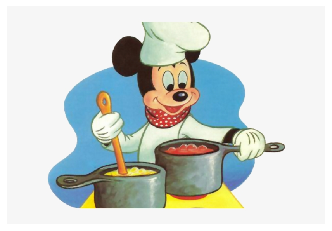


--- Laban's Space features ---
Directness index = 0.48
Goodness of fit = 0.01
Total Space score = 0.25

--- Laban's Time features ---
Average normalized kinetic energy = 0.01
Impulsiveness = 0.20
Total Time score = 0.18


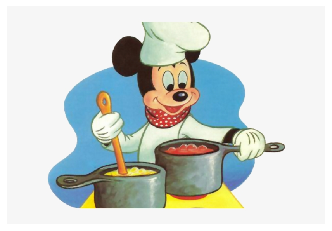


--- Laban's Space features ---
Directness index = 0.99
Goodness of fit = 0.99
Total Space score = 0.99

--- Laban's Time features ---
Average normalized kinetic energy = 0.21
Impulsiveness = 0.15
Total Time score = 0.16

[... UNKNOWN BEHAVIOUR ...]


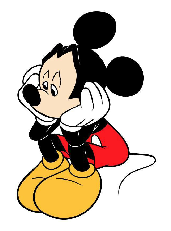

In [8]:
initialize()
root = Tk()
cv   = Canvas(root, width=canvas_size[0], height=canvas_size[1], bg='white')
im   = PIL.Image.new('RGB', canvas_size, 'white')
draw = ImageDraw.Draw(im)
create_widgets()
root.mainloop()